In [1]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import HALO_processing as HALO
import copy
import csv
import math
import os
import time
import pandas as pd
import wind_calc
from scipy import stats

In [2]:
date_set = ['20180317', '20180319', '20180320', '20180322', '20180324', '20180326',\
            '20180328', '20180330', '20180403', '20180404', '20180407']

date_hour = [(int(dd), h) for dd in date_set for h in range(8, 18)]

In [3]:
# previous SF definition
def SourceFactor(aircraft_data, source_name):
    if source_name == 'Taichung':
        lat_source, lon_source = 24.2133, 120.4868
    elif source_name == 'Sixth':
        lat_source, lon_source = 23.8074, 120.2096
    elif source_name == 'Tongxiao':
        lat_source, lon_source = 24.4909, 120.6710
    elif source_name == 'Hsinta':
        lat_source, lon_source = 22.8559772, 120.19658
    elif source_name == 'Dalin':
        lat_source, lon_source = 22.5356535, 120.335592
    #Latitude: 1 deg = 110.574 km
    #Longitude: 1 deg = 111.320*cos(latitude) km
    dx = (aircraft_data['lon']-lon_source)
    dy = (aircraft_data['lat']-lat_source)
    source_distance = np.array(HALO.get_Horizontal_Distance_array(list(aircraft_data['lat']), list(aircraft_data['lon']), lat_source, lon_source))
    horizontal_WS = np.sqrt(aircraft_data['u_ma']**2+aircraft_data['v_ma']**2)
    factor = (dx*aircraft_data['u_ma']+dy*aircraft_data['v_ma'])/np.sqrt(dx**2+dy**2)/horizontal_WS/np.sqrt(source_distance/10)
    return factor

def SourceFactor_epa(lon, lat, u, v, source_name):
    if source_name == 'Taichung':
        lat_source, lon_source = 24.2133, 120.4868
    elif source_name == 'Sixth':
        lat_source, lon_source = 23.8074, 120.2096
    elif source_name == 'Tongxiao':
        lat_source, lon_source = 24.4909, 120.6710
    elif source_name == 'Hsinta':
        lat_source, lon_source = 22.8559772, 120.19658
    elif source_name == 'Dalin':
        lat_source, lon_source = 22.5356535, 120.335592
    #Latitude: 1 deg = 110.574 km
    #Longitude: 1 deg = 111.320*cos(latitude) km
    dx = (lon-lon_source)
    dy = (lat-lat_source)
    source_distance = HALO.get_Horizontal_Distance(lat, lon, lat_source, lon_source)
    horizontal_WS = np.sqrt(u**2+v**2)
    factor = (dx*u+dy*v)/np.sqrt(dx**2+dy**2)/horizontal_WS/np.sqrt(source_distance/10)
    return factor


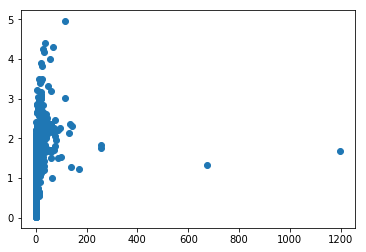

In [4]:
aircraft_data = pd.read_csv('variable_combination_1_min.csv')
aircraft_data['hour'] = aircraft_data['date'].astype(str) +' '+ aircraft_data['Local time'] 
for header in aircraft_data.columns:
    if header not in ['date', 'Local time', 'place', 'hour']:
        aircraft_data[header] = pd.to_numeric(aircraft_data[header], errors='coerce')
    if header in ['SO2', 'NO', 'NOy', 'CO', 'CO2', 'O3_AMTEX', 'CH4', 'O3_FAIROCI']:
        aircraft_data.loc[aircraft_data[header] < 0] = np.nan
aircraft_data['u_ma'] *= 1.9438 # to kts
aircraft_data['v_ma'] *= 1.9438 # to kts
#aircraft_data.loc[:, 'SO2'] /= 1000 # to ppb
aircraft_data['SO2'] /= 1000 # to ppb
aircraft_data['NO2'] = aircraft_data['NO2_MINIDOAS']/1000 # to ppb
#aircraft_data['CO'] /= 1000 # to ppm
aircraft_data['O3'] = np.nanmean([aircraft_data['O3_AMTEX'], aircraft_data['O3_FAIROCI']], axis=0)
aircraft_data['Taichung_SF'] = SourceFactor(aircraft_data, 'Taichung')
aircraft_data['Sixth_SF'] = SourceFactor(aircraft_data, 'Sixth')
aircraft_data['Tongxiao_SF'] = SourceFactor(aircraft_data, 'Tongxiao')
aircraft_data['Hsinta_SF'] = SourceFactor(aircraft_data, 'Hsinta')
aircraft_data['Dalin_SF'] = SourceFactor(aircraft_data, 'Dalin')
#aircraft_data['test_region'] = HALO.in_test_region(aircraft_data['lat'], aircraft_data['lon'], region='continent')
#aircraft_data = aircraft_data[aircraft_data['test_region'] == True]
aircraft_data['SO2_over_CO'] = aircraft_data['SO2']/aircraft_data['CO']
aircraft_data['SO2_over_O3'] = aircraft_data['SO2']/aircraft_data['O3']
aircraft_data['CO_over_NOy'] = aircraft_data['CO']/aircraft_data['NOy']
aircraft_data['TOL_over_BEN'] = aircraft_data['TOL']/aircraft_data['BEN']
aircraft_data['CO_over_O3'] = aircraft_data['CO']/aircraft_data['O3']
aircraft_data['hour'] = aircraft_data['Local time'].str[:2]
aircraft_data['hour'] = aircraft_data['hour'].astype(float)
aircraft_data['P_250_800'] = aircraft_data['P_250_280'] + aircraft_data['P_280_300'] + aircraft_data['P_300_350'] +\
                             aircraft_data['P_350_400'] + aircraft_data['P_400_450'] + aircraft_data['P_450_500'] +\
                             aircraft_data['P_500_580'] + aircraft_data['P_580_650'] + aircraft_data['P_650_700'] + aircraft_data['P_700_800']

aircraft_data['P_250_40000'] = aircraft_data['P_250_800'] + aircraft_data['P_800_1000'] + aircraft_data['P_1000_1300'] +\
                             aircraft_data['P_1300_1600'] + aircraft_data['P_1600_2000'] + aircraft_data['P_2000_2500'] +\
                             aircraft_data['P_2500_3000'] + aircraft_data['P_3000_3500'] + aircraft_data['P_3500_4000'] +\
                             aircraft_data['P_4000_5000'] + aircraft_data['P_5000_6500'] + aircraft_data['P_6500_7500'] +\
                             aircraft_data['P_7500_8500'] + aircraft_data['P_8500_10000'] + aircraft_data['P_10000_12500'] +\
                             aircraft_data['P_12500_15000'] + aircraft_data['P_15000_17500'] + aircraft_data['P_17500_20000'] +\
                             aircraft_data['P_20000_25000'] + aircraft_data['P_25000_30000'] + aircraft_data['P_30000_32000'] + aircraft_data['P_32000_40000']
aircraft_data['CPC-P_250_40000'] = aircraft_data['CPC3_CONC_CM3_AMB'] - aircraft_data['P_250_40000']
aircraft_data['CCN_over_P_250_800'] = aircraft_data['CCN']/aircraft_data['P_250_800']
aircraft_data['CCN_over_CPC'] = aircraft_data['CCN']/aircraft_data['CPC3_CONC_CM3_AMB']
aircraft_data['CCN_over_SO4'] = aircraft_data['CCN']/aircraft_data['SO4']
aircraft_data['CCN_over_NO3'] = aircraft_data['CCN']/aircraft_data['NO3']
aircraft_data['CCN_over_ORG'] = aircraft_data['CCN']/aircraft_data['ORG']
aircraft_data['SO2_weight_conc'] = aircraft_data['SO2']*0.064/(8.3145*aircraft_data['Total_Air_Temp']/(aircraft_data['static_P']*100))
aircraft_data['SO4_oxi_ratio'] = aircraft_data['SO4']/(aircraft_data['SO4']+aircraft_data['SO2_weight_conc'])
aircraft_data['SO3'] = aircraft_data['CO2']/aircraft_data['CO']*aircraft_data['SO2']*aircraft_data['MIXRATIOM_H2O']
#print(aircraft_data['SO3'].describe())
plt.scatter(aircraft_data['SO3'], aircraft_data['SO4'])
plt.show()

In [5]:
# set map region
minLat, maxLat =  21.75, 25.75
minLon, maxLon =  119.4, 122.5

# EPA stations location input
epa_locations = {'Erlin':(23.925346, 120.409577, 15.9 + 11.5),
                 'Sanyi':(24.3889606, 120.7557614, 373.8 + 10),
                 'Dali':(24.0994821, 120.6779397, 49.2 + 16.5),
                 'Douliu':(23.7133968, 120.5454533, 55.2 + 18.5),
                 'Annan':(23.0483636, 120.2182135, 5.4 + 15.4),
                 'Puzi':(23.4670248, 120.2477994, 9.7 + 3.5),
                 'Zhushan':(23.7562297, 120.6782633, 163.5 + 11.5),
                 'Zhudong':(24.7398844, 121.0881989, 119.2 + 14.5),
                 'Xitun':(24.1606793, 120.6171796, 80.1 + 15.5),
                 'Shalu':(24.2251755, 120.5692086, 57.5 + 19.5),
                 'Zhongming':(24.1513789, 120.6417563, 70.9 + 17.5),
                 'Nantou':(23.9134307, 120.6867432, 91.6 + 16.5),
                 'Meinong':(22.883998, 120.5303368, 46.2 + 11),
                 'Miaoli':(24.564855, 120.820739, 53.1 + 14.5),
                 'Puli':(23.9756883, 120.970191, 459.2 + 19.5),
                 'Magong':(23.5695543, 119.566316, 18.9 + 15),
                 'Lunbei':(23.7579343, 120.3491074, 19.6 + 14.5),
                 'Mailiao':(23.7534885, 120.2520018, 8.8 + 12.5),
                 'Shanhua':(23.114283, 120.298477, 11.1 + 4.5),
                 'Hsinchu':(24.8049301, 120.9723226, 27.0 + 15.5),
                 'Xingang':(23.5559483, 120.3449037, 18.4 + 15.5),
                 'Xinying':(23.3065699, 120.317553, 18.0 + 10.5),
                 'Nanzi':(22.7334902, 120.3278826, 20.9 + 13.5),
                 'Chiayi':(23.4632867, 120.4408782, 36.0 + 17.5),
                 'Changhua':(24.0656149, 120.541813, 20.5 + 14.5),
                 'Taixi':(23.7170507, 120.2016901, 4.0 + 15.5),
                 'Tainan':(22.9848031, 120.2032338, 20.7 + 11.5),
                 'Fengshan':(22.6276584, 120.3574431, 19.2 + 13.5),
                 'Xianxi':(24.1321046, 120.4692213, 6.5 + 15.5),
                 'Qiaotou':(22.7576591, 120.30575, 9.1 + 11.0),
                 'Toufen':(24.6962647, 120.8991162, 17.4 + 14.5),
                 'Fengyuan':(24.2558681, 120.7414285, 250.1 + 16.5),
                 }

location_plot = ['location_0312','location_0317','location_0319','location_0320','location_0322','location_0324','location_0326',\
                'location_0328','location_0330','location_0403','location_0404','location_0407']

location_plot = ['location_0312','location_0317','location_0319','location_0320','location_0322','location_0324','location_0326',\
                'location_0328','location_0330','location_0403','location_0404','location_0407']



In [6]:
class Point():
    def __init__(self, lat, lon):
        self.lat = lat
        self.lon = lon
    def slope(self, p2):
        return (p2.lat-self.lat)/(p2.lon-self.lon)
    def intercept(self, p2):
        return (p2.lat-p2.lon*self.slope(p2))
class Line():
    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept
    def cal_lon(self, lat_position):
        return Point(lat_position, (lat_position-self.intercept)/self.slope)
            
def sub_region_test(lat, lon, region='offshore', boundary_only=False):
    #test if the location is offshore
    p_ul = Point(24.72, 120.56-0.04)
    p_ll = Point(22.99, 119.90-0.04)
    p_ur = Point(24.60, 120.80)
    p_lr = Point(23.10, 120.24)
    
    L_ul  = Line(p_ul.slope(p_ll), p_ul.intercept(p_ll))
    L_ur = Line(p_ur.slope(p_lr), p_ur.intercept(p_lr))
    separation_L1 = Point(24.43, 120.56)
    separation_R1 = Point(24.42, 120.72)
    separation_L2 = Point(23.41, 120.02)
    separation_R2 = Point(23.33, 120.36)
    if region == 'offshore':
        p1 = Point(22.99,119.84) #pLR 
        p2 = Point(23.02,119.74) #pLL
        p3 = Point(24.75,120.48) #pUL
        p4 = Point(24.72,120.58) #pUR
    elif region == 'region_a':
        p1 = L_ur.cal_lon(24.32) #pLR 
        p2 = L_ul.cal_lon(24.32) #pLL
        p3 = Point(24.65, 120.54) #pUL
        p4 = Point(24.65, 120.86) #pUR
    elif region == 'region_b':
        p1 = L_ur.cal_lon(23.90) #pLR 
        p2 = L_ul.cal_lon(23.90) #pLL
        p3 = L_ul.cal_lon(24.32) #pUL
        p4 = L_ur.cal_lon(24.32) #pUR
    elif region == 'region_c':
        p1 = L_ur.cal_lon(23.52) #pLR 
        p2 = L_ul.cal_lon(23.52) #pLL
        p3 = L_ul.cal_lon(23.90) #pUL
        p4 = L_ur.cal_lon(23.90) #pUR
    elif region == 'region_d':
        p1 = L_ur.cal_lon(23.19) #pLR 
        p2 = Point(23.19, 119.94) #pLL
        p3 = L_ul.cal_lon(23.52) #pUL
        p4 = L_ur.cal_lon(23.52) #pUR
    elif region == 'region_e':
        p1 = L_ur.cal_lon(22.70) #pLR 
        p2 = L_ul.cal_lon(22.70) #pLL
        p3 = L_ul.cal_lon(23.10) #pUL
        p4 = L_ur.cal_lon(23.10) #pUR
    elif region == 'region_g':
        p1 = L_ur.cal_lon(22.60) #pLR 
        p2 = L_ul.cal_lon(22.60) #pLL
        p3 = L_ul.cal_lon(22.90) #pUL
        p4 = L_ur.cal_lon(22.90) #pUR
    elif region == 'south_sea':
        p1 = Point(22.70, 120.38) #pLR 
        p2 = Point(22.70, 120.14) #pLL
        p3 = Point(23.19, 119.94) #pUL
        p4 = Point(23.19, 120.24) #pUR
        
    elif region == 'continent':
        p1 = Point(22.95, 120.22) #pLR 
        p2 = Point(22.99, 119.84) #pLL
        p3 = Point(24.72, 120.58) #pUL
        p4 = Point(24.60, 120.85) #pUR
    elif region == 'industrial':
        p1 = Point(23.65, 120.35) #pLR 
        p2 = Point(23.64, 120.10) #pLL
        p3 = Point(24.31, 120.37) #pUL
        p4 = Point(24.30, 120.55) #pUR
    if boundary_only:
        return (p1, p2, p3, p4)
    else:
        L1 = Line(p1.slope(p2), p1.intercept(p2))
        L2 = Line(p2.slope(p3), p2.intercept(p3))
        L3 = Line(p3.slope(p4), p3.intercept(p4))
        L4 = Line(p4.slope(p1), p4.intercept(p1))
        if L1.slope >= 0:
            cal_L1 = (L1.slope*lon - lat + L1.intercept) < 0
        else:
            cal_L1 = (L1.slope*lon - lat + L1.intercept) < 0
        if L2.slope > 0:
            cal_L2 = (L2.slope*lon - lat + L2.intercept) > 0
        else:
            cal_L2 = (L2.slope*lon - lat + L2.intercept) < 0
        if L3.slope <= 0:
            cal_L3 = (L3.slope*lon - lat + L3.intercept) > 0
        else:
            cal_L3 = (L3.slope*lon - lat + L3.intercept) > 0
        if L4.slope > 0:
            cal_L4 = (L4.slope*lon - lat + L4.intercept) < 0
        else:
            cal_L4 = (L4.slope*lon - lat + L4.intercept) > 0

        return np.logical_and(np.logical_and(cal_L1, cal_L2), np.logical_and(cal_L3, cal_L4))

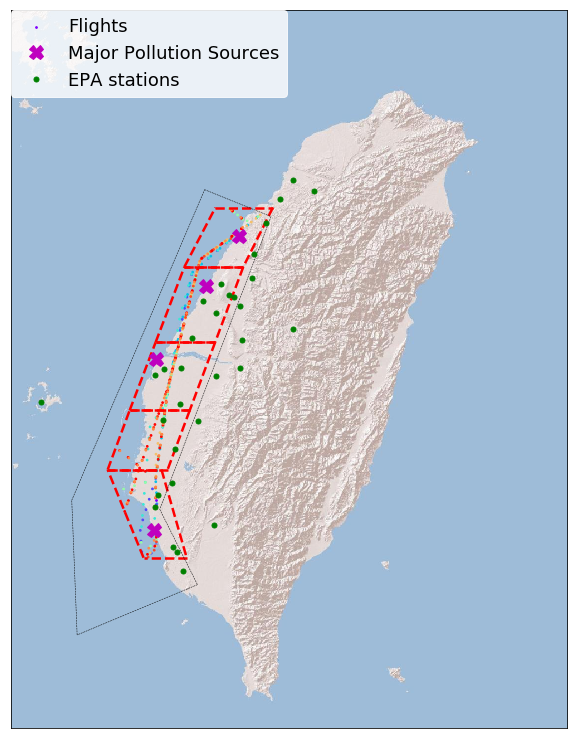

In [7]:
# west-coast-upper
pLR = (22.97,120.23) 
pUR = (24.6, 120.85)
pLL = (23.02,119.74)
pUL = (24.75,120.48)

# west-coast-lower
lUR = (22.97,120.23) 
lLL = (22.27,119.77)
lLR = (22.55,120.44)
lUL = (23.02,119.74)



fig = plt.figure(figsize=(14, 10.5))
ax1 = fig.add_axes([0.05, 0.05, 0.95, 0.95])

cmap = matplotlib.cm.get_cmap('rainbow')
#for i in range(len(location_plot)):
#    loc_date = location_plot[i]
#    lon = [i[0] for i in vars()[loc_date]]
#    lat = [i[1] for i in vars()[loc_date]]
#    flight, = ax1.plot(lon, lat, color=cmap(1/11*i), label='Flights', linewidth=2)

for region_plot in ['region_a', 'region_b', 'region_c', 'region_d', 'south_sea',]: #'industrial'
    temp_aircraft = aircraft_data[sub_region_test(np.array(aircraft_data['lat']), np.array(aircraft_data['lon']), region=region_plot)]
    for d in date_set:
        dd = int(d)
        temp_aircraft_2 = temp_aircraft[np.logical_and(temp_aircraft['date']==dd, temp_aircraft['height_in_hundred']==600)]
        flight = ax1.scatter(temp_aircraft_2['lon'], temp_aircraft_2['lat'], c=[cmap(1/11*(dd%13)) for _ in range(len(temp_aircraft_2))], label='Flights', s=3)
    (p1, p2, p3, p4) = sub_region_test(24.0, 121.0, region=region_plot, boundary_only=True)
    line_setting_2 = dict(linestyle='--', linewidth=2.5)
    ax1.plot([p1.lon,p2.lon],[p1.lat,p2.lat], **line_setting_2, color='r')
    ax1.plot([p2.lon,p3.lon],[p2.lat,p3.lat], **line_setting_2, color='r')
    ax1.plot([p3.lon,p4.lon],[p3.lat,p4.lat], **line_setting_2, color='r')
    ax1.plot([p4.lon,p1.lon],[p4.lat,p1.lat], **line_setting_2, color='r')

    
line_setting = dict(linestyle='--', color='k', linewidth=0.5)
#ax1.plot([pLR[1],pLL[1]],[pLR[0],pLL[0]], **line_setting)
ax1.plot([pLL[1],pUL[1]],[pLL[0],pUL[0]], **line_setting)
ax1.plot([pUL[1],pUR[1]],[pUL[0],pUR[0]], **line_setting)
ax1.plot([pUR[1],pLR[1]],[pUR[0],pLR[0]], **line_setting)

ax1.plot([lLR[1],lLL[1]],[lLR[0],lLL[0]], **line_setting)
ax1.plot([lLL[1],lUL[1]],[lLL[0],lUL[0]], **line_setting)
#ax1.plot([lUL[1],lUR[1]],[lUL[0],lUR[0]], **line_setting)
ax1.plot([lUR[1],lLR[1]],[lUR[0],lLR[0]], **line_setting)



for keys in epa_locations:
    place_epa, = ax1.plot(epa_locations[keys][1], epa_locations[keys][0], color="g", linewidth=0, marker='o', markersize=5, zorder=5, label='EPA stations')

m = Basemap(projection='cyl',resolution='h',llcrnrlat=minLat, \
    urcrnrlat = maxLat, llcrnrlon = minLon, urcrnrlon = maxLon, ax=ax1)
m.arcgisimage(service='World_Shaded_Relief', xpixels = 1000, verbose= False, alpha=0.1)

source_arg = dict(marker='X', markersize=14, linestyle='None', zorder=3)
place_source, = ax1.plot(120.6710, 24.4909, c='m', label='Major Pollution Sources', **source_arg)
ax1.plot(120.4868, 24.2133, c='m', **source_arg)
ax1.plot(120.2096, 23.8074, c='m', **source_arg)
ax1.plot(120.1966, 22.8560, c='m', **source_arg)

legend_line = [flight, place_source, place_epa]
legend = ax1.legend(handles=legend_line, loc='upper left', borderaxespad=0, fontsize=18, edgecolor='white', frameon=True)
#legend.get_frame().set_alpha(0)
legend.get_frame().set_facecolor('white')
plt.show()
#fig.savefig('/data1/home/yuwenchen/Emerge-Asia/west_coast_region.png', dpi=300,bbox_inches="tight")
plt.close()

1302
Height: 600m
type       region       data #   slope      err       R2      SO4     err
airborne   region_a       46    059.645 +- 03.924   0.840    1.63 +- 0.057
airborne   region_b       66    047.708 +- 05.029   0.584    1.66 +- 0.072
airborne   region_c       61    030.569 +- 02.982   0.640    1.88 +- 0.083
airborne   region_d       62    038.875 +- 04.086   0.601    1.85 +- 0.089
airborne   south_sea      52    016.740 +- 01.709   0.658    2.03 +- 0.093


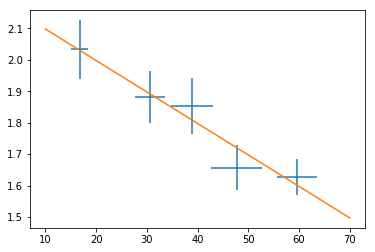

slope: -0.010010927426574433
R2:    0.9401774234024692


In [8]:
print(aircraft_data.shape[0])
hh = 600
print('Height: {}m'.format(hh))
slope, slope_err, so4, so4_err = ([] for _ in range(4))
print('{:8s}   {:12s} {:6s}   {:7s}    {:6s}    {:4s}    {:4s}    {:3s}'.format('type', 'region', 'data #', 'slope', 'err', 'R2', 'SO4', 'err'))

for region_name in ['region_a', 'region_b', 'region_c', 'region_d', 'south_sea']: # 'industrial', 'continent',
    temp_aircraft = aircraft_data[sub_region_test(np.array(aircraft_data['lat']), np.array(aircraft_data['lon']), region=region_name) == True]
    temp_aircraft = temp_aircraft[np.logical_and((temp_aircraft['height_in_hundred'] >= hh), (temp_aircraft['height_in_hundred'] <= hh))]
    #print('max SO2:', temp_aircraft['SO2'].max(), 'max CO:', temp_aircraft['CO'].max())
    mask_2 = ~np.isnan(temp_aircraft['SO2_over_O3']) & ~np.isnan(temp_aircraft['CO_over_O3'])
    num = mask_2.sum()
    #print(num)
    if num > 0:
        slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(temp_aircraft['SO2_over_O3'][mask_2], temp_aircraft['CO_over_O3'][mask_2])
        print('airborne   {:12s}   {:2d}    {:07.3f} +- {:06.3f}   {:.3f}    {:4.2f} +- {:04.3f}'.format(region_name, num, slope_2, std_err_2, r_value_2**2, temp_aircraft['SO4'].mean(), temp_aircraft['SO4'].std()/np.sqrt(num)))
        if r_value_2**2 >= 0.399:
            slope.append(slope_2)
            slope_err.append(std_err_2)
            so4.append(temp_aircraft['SO4'].mean())
            so4_err.append(temp_aircraft['SO4'].std()/np.sqrt(num))
slope_3, intercept_3, r_value_3, p_value_3, std_err_3 = stats.linregress(slope, so4)
plt.errorbar(slope, so4, xerr=slope_err, yerr=so4_err, linestyle="None")
plt.plot([10, 70], [slope_3*10+intercept_3, slope_3*70+intercept_3])
plt.show()
print('slope:', slope_3)
print('R2:   ', r_value_3**2)

In [9]:
def plot_region_corr(region_name):
    temp_aircraft = aircraft_data[sub_region_test(np.array(aircraft_data['lat']), np.array(aircraft_data['lon']), region=region_name) == True]
    temp_aircraft = temp_aircraft[temp_aircraft['height_in_hundred'] == 600]
    mask_2 = ~np.isnan(temp_aircraft['SO2_over_O3']) & ~np.isnan(temp_aircraft['CO_over_O3'])

    fig = plt.figure(figsize=(6, 4.5))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    #ax.scatter(epa_SO2/epa_O3, epa_CO/epa_O3, s=epa_scatter_s, c=epa_hour, label=epa_label, alpha=epa_scatter_alpha, marker='s')
    ax.scatter(temp_aircraft['SO2_over_O3'], temp_aircraft['CO_over_O3'], s=50, c=temp_aircraft['hour'], label='airborne', alpha=1, marker='^')
    #ax.legend(**legend_dict)

    label_fontsize = 20
    ytick_size = 16

    ax.axhline(y=0.0, linestyle='--', c='k', linewidth=0.5)
    ax.set_ylim(0, 60)
    ax.set_xlim(0, 1)
    ax.set_xlabel('$\mathregular{[SO_2]}$/$\mathregular{[O_3]}$', color='k', fontsize=label_fontsize, labelpad=10)
    ax.set_ylabel('[CO]/$\mathregular{[O_3]}$', color='k', fontsize=label_fontsize, labelpad=10)
    ax.xaxis.set_tick_params(labelsize=ytick_size)
    ax.yaxis.set_tick_params(labelsize=ytick_size)
    ax.set_title(region_name, fontsize=24)
    mask_2 = ~np.isnan(temp_aircraft['SO2_over_O3']) & ~np.isnan(temp_aircraft['CO_over_O3'])
    slope_2, intercept_2, r_value_2, p_value_2, std_err_2 = stats.linregress(temp_aircraft['SO2_over_O3'][mask_2], temp_aircraft['CO_over_O3'][mask_2])
    x3, x4 = 0.0, 18
    ax.text(0.05, 55, 'data #: %2d' %mask_2.sum(), fontsize=16)
    ax.text(0.05, 48, 'slope:   %.3f' %slope_2, fontsize=16)
    ax.text(0.05, 41, '$\mathregular{R^2}$:        %.3f' %r_value_2**2, fontsize=16)
    y3, y4 = x3*slope_2+intercept_2, x4*slope_2+intercept_2
    ax.plot([x3, x4], [y3, y4], c='r', linewidth=2, zorder=1)
   

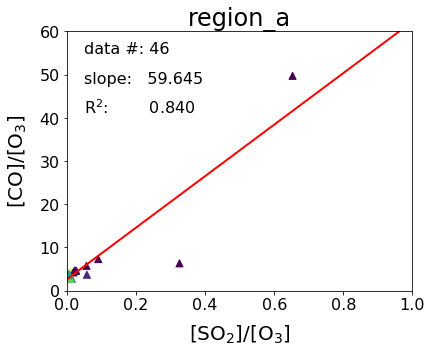

In [10]:
plot_region_corr('region_a')

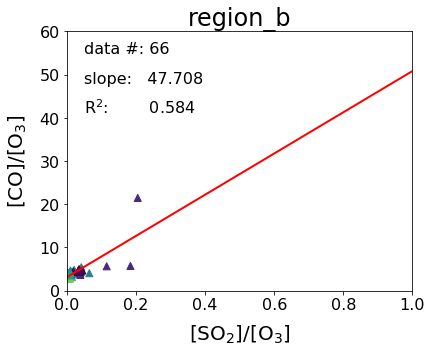

In [11]:
plot_region_corr('region_b')

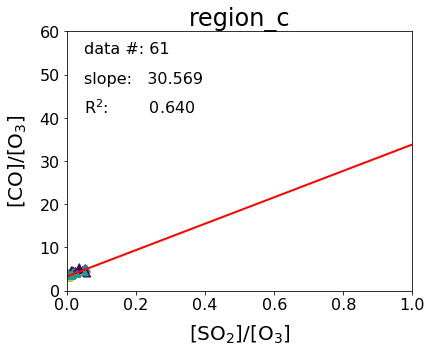

In [12]:
plot_region_corr('region_c')

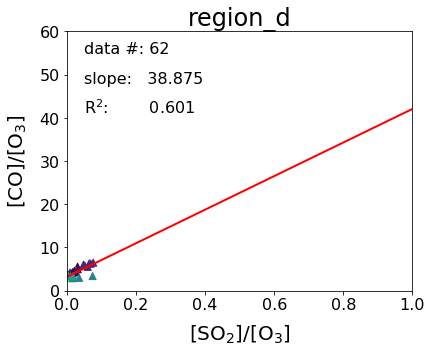

In [13]:
plot_region_corr('region_d')

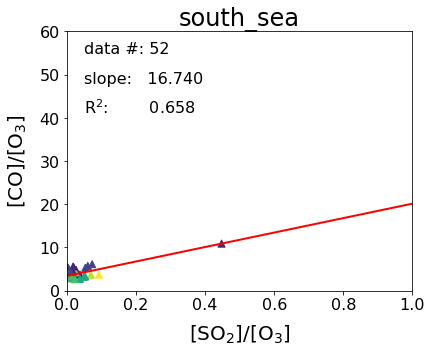

In [14]:
plot_region_corr('south_sea')